In [1]:
# This piece of software is bound by The MIT License (MIT)
# Copyright (c) 2013 Siddharth Agrawal
# Code written by : Siddharth Agrawal
# Email ID : siddharth.950@gmail.com

import numpy
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot

###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        #note: this is that p term
        self.lamda = lamda                  # weight decay parameter? 
        # I didn't realize they'd still include this regularization too.
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        # No idea what's going on here...
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1) # I would have thought just the
        # visible size in denominator for W1, becasue that's the number into each hidden node. I don't know
        # Why the 6 is used. 
        
        rand = numpy.random.RandomState(int(time.time())) # Clever
        
        W1 = numpy.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = numpy.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = numpy.zeros((hidden_size, 1))
        b2 = numpy.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """
        #Question: why this?
        self.theta = numpy.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + numpy.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        # why they are doing this... I don't know.
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        # full-batch approach.
        hidden_layer = self.sigmoid(numpy.dot(W1, input) + b1) # note that input examples are going to be in columns I think
        # So the shape of hidden layer will be activations down the columns, with a new training eg per column
        output_layer = self.sigmoid(numpy.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = numpy.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input #It's like they are using a cross entropy cost. no.
        
        sum_of_squares_error = 0.5 * numpy.sum(numpy.multiply(diff, diff)) / input.shape[1] # cumulative measure.
        weight_decay         = 0.5 * self.lamda * (numpy.sum(numpy.multiply(W1, W1)) +
                                                   numpy.sum(numpy.multiply(W2, W2))) # It's element wise multiplication
        # I don't understand what kind of regulatization they are doing here. It's not L2. or L1.
        #It's a decay that changes based on sum of total weights.
        
        # Ah, the weight decay isn't the derivitive, but just the cost associated with the weights, the penalty
        # Term.
        
        #rho_cap is the  average activation of that neuron in hidden layer
        KL_divergence        = self.beta * numpy.sum(self.rho * numpy.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * numpy.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        #I think this'll automatically assume the dimension of rho_cap. the # of hiddens is # rows, and 1 column
        
        # Question: What are they doing with this del_out? This isn't making much sense... 
        # Oh, of course! The derivative of the sigmoid function is the value of the sigmoid*(1-sigmoid)
        # which means they are not using cross-entropy cost function, but rather the mse. I would think this would slow
        #learning. Proper initialization would help with that tho.
        del_out = numpy.multiply(diff, numpy.multiply(output_layer, 1 - output_layer))
        
        # structure: egs stored in each column. there are as many del_out as output neurons
        
        del_hid = numpy.multiply(numpy.dot(numpy.transpose(W2), del_out) + numpy.transpose(numpy.matrix(KL_div_grad)), 
                                 numpy.multiply(hidden_layer, 1 - hidden_layer)) # This last is the sigma*(1-sigma)
        # think the addition of the np.matrix(KL_div_grad) gets applied to each example (column) in the np.dot().
        
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = numpy.dot(del_hid, numpy.transpose(input)) # is [hiddens, examples] x [ examples, inputs]
        # So you get W_11 = sum(all first hidden neuron*all first input), W_12 = sum(all first hidden * all second input)
        W2_grad = numpy.dot(del_out, numpy.transpose(hidden_layer))
        b1_grad = numpy.sum(del_hid, axis = 1)
        b2_grad = numpy.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1 # rescale the gradient to make it the average
        # and implement the L2 regularization
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = numpy.array(W1_grad)
        W2_grad = numpy.array(W2_grad)
        b1_grad = numpy.array(b1_grad)
        b2_grad = numpy.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = numpy.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]

###########################################################################################
""" Normalize the dataset provided as input """

def normalizeDataset(dataset):

    """ Remove mean of dataset """

    dataset = dataset - numpy.mean(dataset)
    
    """ Truncate to +/-3 standard deviations and scale to -1 to 1 """
    
    std_dev = 3 * numpy.std(dataset)
    dataset = numpy.maximum(numpy.minimum(dataset, std_dev), -std_dev) / std_dev
    
    """ Rescale from [-1, 1] to [0.1, 0.9] """
    
    dataset = (dataset + 1) * 0.4 + 0.1
    
    return dataset

###########################################################################################
""" Randomly samples image patches, normalizes them and returns as dataset """
# It's cool that with this unsupervised stuff, you can
def loadDataset(num_patches, patch_side):

    """ Load images into numpy array """

    images = scipy.io.loadmat('IMAGES.mat')
    images = images['IMAGES']
    
    """ Initialize dataset as array of zeros """
    
    dataset = numpy.zeros((patch_side*patch_side, num_patches))
    
    """ Initialize random numbers for random sampling of images
        There are 10 images of size 512 X 512 """
    
    rand = numpy.random.RandomState(int(time.time()))
    image_indices = rand.randint(512 - patch_side, size = (num_patches, 2))
    image_number  = rand.randint(10, size = num_patches)
    
    """ Sample 'num_patches' random image patches """
    
    for i in xrange(num_patches):
    
        """ Initialize indices for patch extraction """
    
        index1 = image_indices[i, 0]
        index2 = image_indices[i, 1]
        index3 = image_number[i]
        
        """ Extract patch and store it as a column """
        
        patch = images[index1:index1+patch_side, index2:index2+patch_side, index3]
        patch = patch.flatten()
        dataset[:, i] = patch
    
    """ Normalize and return the dataset """
    
    dataset = normalizeDataset(dataset)
    return dataset

###########################################################################################
""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side), # the opt_W1 is the same structure
                            # as the W1. It's got all W1 going into a hidden node in a single row corresponding to that node.
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()

###########################################################################################
""" Loads data, trains the Autoencoder and visualizes the learned weights """

def executeSparseAutoencoder():

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = 8      # side length of sampled image patches
    hid_patch_side = 5      # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = 10000  # number of training examples
    max_iterations = 400    # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
    """ Load randomly sampled image patches as dataset """
    
    training_data = loadDataset(num_patches, vis_patch_side)
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    # Woah, don't know that. But i think grad desc would also work. This must do somehting different
    # with the gradient updates after the gradients are calculated. Rather than just the 
    # w = (1-decay)*w - eta*grad_w
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations})
    opt_theta     = opt_solution.x
    opt_W1        = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    
    """ Visualize the obtained optimal W1 weights """
    
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)

executeSparseAutoencoder()

FileNotFoundError: [Errno 2] No such file or directory: 'IMAGES.mat'

In [3]:
a = numpy.array([[2,9],[4,5]])
b = numpy.array([[2,1],[2,5]])
print(numpy.multiply(a,b))

[[ 4  9]
 [ 8 25]]


In [30]:
# This piece of software is bound by The MIT License (MIT)
# Copyright (c) 2013 Siddharth Agrawal
# Code written by : Siddharth Agrawal
# Email ID : siddharth.950@gmail.com

import numpy
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot




###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        #note: this is that p term
        self.lamda = lamda                  # weight decay parameter? 
        # I didn't realize they'd still include this regularization too.
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1) # I would have thought just the
        # visible size in denominator for W1, becasue that's the number into each hidden node. I don't know
        # Why the 6 is used. 
        
        rand = numpy.random.RandomState(int(time.time())) # Clever
        
        W1 = numpy.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = numpy.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = numpy.zeros((hidden_size, 1))
        b2 = numpy.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """
        #Question: why this?
        self.theta = numpy.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + numpy.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        # why they are doing this... I don't know.
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        # full-batch approach.
        hidden_layer = self.sigmoid(numpy.dot(W1, input) + b1) # note that input examples are going to be in columns I think
        # So the shape of hidden layer will be activations down the columns, with a new training eg per column
        output_layer = self.sigmoid(numpy.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = numpy.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input #It's like they are using a cross entropy cost. no.
        
        sum_of_squares_error = 0.5 * numpy.sum(numpy.multiply(diff, diff)) / input.shape[1] # cumulative measure.
        weight_decay         = 0.5 * self.lamda * (numpy.sum(numpy.multiply(W1, W1)) +
                                                   numpy.sum(numpy.multiply(W2, W2))) # It's element wise multiplication
        # I don't understand what kind of regulatization they are doing here. It's not L2. or L1.
        #It's a decay that changes based on sum of total weights.
        
        # Ah, the weight decay isn't the derivitive, but just the cost associated with the weights, the penalty
        # Term.
        
        #rho_cap is the  average activation of that neuron in hidden layer
        KL_divergence        = self.beta * numpy.sum(self.rho * numpy.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * numpy.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        #I think this'll automatically assume the dimension of rho_cap. the # of hiddens is # rows, and 1 column
        
        # Question: What are they doing with this del_out? This isn't making much sense... 
        # Oh, of course! The derivative of the sigmoid function is the value of the sigmoid*(1-sigmoid)
        # which means they are not using cross-entropy cost function, but rather the mse. I would think this would slow
        #learning. Proper initialization would help with that tho.
        del_out = numpy.multiply(diff, numpy.multiply(output_layer, 1 - output_layer))
        
        # structure: egs stored in each column. there are as many del_out as output neurons
        
        del_hid = numpy.multiply(numpy.dot(numpy.transpose(W2), del_out) + numpy.transpose(numpy.matrix(KL_div_grad)), 
                                 numpy.multiply(hidden_layer, 1 - hidden_layer)) # This last is the sigma*(1-sigma)
        # think the addition of the np.matrix(KL_div_grad) gets applied to each example (column) in the np.dot().
        
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = numpy.dot(del_hid, numpy.transpose(input)) # is [hiddens, examples] x [ examples, inputs]
        # So you get W_11 = sum(all first hidden neuron*all first input), W_12 = sum(all first hidden * all second input)
        W2_grad = numpy.dot(del_out, numpy.transpose(hidden_layer))
        b1_grad = numpy.sum(del_hid, axis = 1)
        b2_grad = numpy.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1 # rescale the gradient to make it the average
        # and implement the L2 regularization
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = numpy.array(W1_grad)
        W2_grad = numpy.array(W2_grad)
        b1_grad = numpy.array(b1_grad)
        b2_grad = numpy.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = numpy.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]

###########################################################################################
""" Normalize the dataset provided as input """

def normalizeDataset(dataset):

    """ Remove mean of dataset """

    dataset = dataset - numpy.mean(dataset)
    
    """ Truncate to +/-3 standard deviations and scale to -1 to 1 """
    
    std_dev = 3 * numpy.std(dataset)
    dataset = numpy.maximum(numpy.minimum(dataset, std_dev), -std_dev) / std_dev
    
    """ Rescale from [-1, 1] to [0.1, 0.9] """
    
    dataset = (dataset + 1) * 0.4 + 0.1
    
    return dataset

###########################################################################################
""" Randomly samples image patches, normalizes them and returns as dataset """
# It's cool that with this unsupervised stuff, you can
def loadDataset(num_patches, patch_side, data):

    """ Load images into numpy array """

   
    images = data.reshape(len(data),28,28)
    
    """ Initialize dataset as array of zeros """
    
    dataset = numpy.zeros((patch_side*patch_side, num_patches))
    
    """ Initialize random numbers for random sampling of images
        There are 10 images of size 28x28 """
    
    rand = numpy.random.RandomState(int(time.time()))
    image_indices = rand.randint(28 - patch_side, size = (num_patches, 2)) 
    # giving you a big array of indices to put the upper left corner of patch
    image_number  = rand.randint(10, size = num_patches)
    # Which image to draw from
    
    """ Sample 'num_patches' random image patches """
    
    for i in range(num_patches):
    
        """ Initialize indices for patch extraction """
    
        index1 = image_indices[i, 0]
        index2 = image_indices[i, 1]
        index3 = image_number[i]
        
        """ Extract patch and store it as a column """
        
        patch = images[index3, index1:index1+patch_side, index2:index2+patch_side]
        # So the images are dims 1,2 are x,y and dim3 is image examples
        patch = patch.flatten()
        dataset[:, i] = patch
    
    """ Normalize and return the dataset """
    
    dataset = normalizeDataset(dataset)
    return dataset

###########################################################################################
""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side), # the opt_W1 is the same structure
                            # as the W1. It's got all W1 going into a hidden node in a single row corresponding to that node.
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()

###########################################################################################
""" Loads data, trains the Autoencoder and visualizes the learned weights """

def executeSparseAutoencoder(data):

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = 8      # side length of sampled image patches
    hid_patch_side = 5      # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = 10000  # number of training examples
    max_iterations = 400    # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
    """ Load randomly sampled image patches as dataset """
    
    training_data = loadDataset(num_patches, vis_patch_side, data)
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    # Woah, don't know that. But i think grad desc would also work. This must do somehting different
    # with the gradient updates after the gradients are calculated. Rather than just the 
    # w = (1-decay)*w - eta*grad_w
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations})
    opt_theta     = opt_solution.x
    opt_W1        = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    
    """ Visualize the obtained optimal W1 weights """
    
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)


In [2]:
# The data
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)[:10]
unlabeled_data = np.array([data[0] for data in training_data])


In [7]:
d = unlabeled_data

10


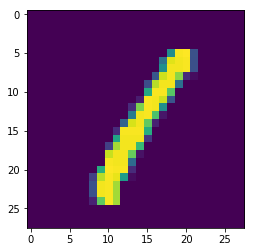

(8, 8)


In [27]:
d = d.reshape(len(d),28,28)
print(len(d))
import matplotlib.pyplot as plt
plt.imshow(d[3])
plt.show()
# The reshape works

patch_side = 8
rand = numpy.random.RandomState(int(time.time()))
image_indices = rand.randint(28 - patch_side, size = (1, 2)) 
# giving you a big array of indices to put the upper left corner of patch
image_number  = rand.randint(10, size = 1)
    
index1 = image_indices[0, 0]
index2 = image_indices[0, 1]
index3 = image_number[0]
patch = d[index3,index1:index1+patch_side, index2:index2+patch_side]
print(patch.shape)

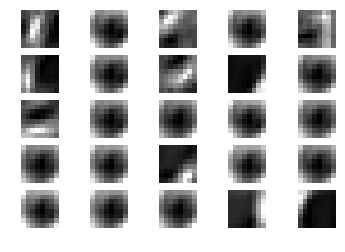

In [31]:
executeSparseAutoencoder(unlabeled_data)

Now I'm going to try to run it on the entire number images, rather than just on these small patches.

In [52]:
# This piece of software is bound by The MIT License (MIT)
# Copyright (c) 2013 Siddharth Agrawal
# Code written by : Siddharth Agrawal
# Email ID : siddharth.950@gmail.com

import numpy
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot




###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        #note: this is that p term
        self.lamda = lamda                  # weight decay parameter? 
        # I didn't realize they'd still include this regularization too.
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1) # I would have thought just the
        # visible size in denominator for W1, becasue that's the number into each hidden node. I don't know
        # Why the 6 is used. 
        
        rand = numpy.random.RandomState(int(time.time())) # Clever
        
        W1 = numpy.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = numpy.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = numpy.zeros((hidden_size, 1))
        b2 = numpy.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """
        #Question: why this?
        self.theta = numpy.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + numpy.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        # why they are doing this... I don't know.
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        # full-batch approach.
        hidden_layer = self.sigmoid(numpy.dot(W1, input) + b1) # note that input examples are going to be in columns I think
        # So the shape of hidden layer will be activations down the columns, with a new training eg per column
        output_layer = self.sigmoid(numpy.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = numpy.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input #It's like they are using a cross entropy cost. no.
        
        sum_of_squares_error = 0.5 * numpy.sum(numpy.multiply(diff, diff)) / input.shape[1] # cumulative measure.
        # We just divide by the number of example points.
        weight_decay         = 0.5 * self.lamda * (numpy.sum(numpy.multiply(W1, W1)) +
                                                   numpy.sum(numpy.multiply(W2, W2)))
        
        # Ah, the weight decay isn't the derivitive, but just the cost associated with the weights, the penalty
        # Term.
        
        #rho_cap is the  average activation of that neuron in hidden layer
        KL_divergence        = self.beta * numpy.sum(self.rho * numpy.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * numpy.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        #I think this'll automatically assume the dimension of rho_cap. the # of hiddens is # rows, and 1 column
        
        # Question: What are they doing with this del_out? This isn't making much sense... 
        # Oh, of course! The derivative of the sigmoid function is the value of the sigmoid*(1-sigmoid)
        # which means they are not using cross-entropy cost function, but rather the mse. I would think this would slow
        #learning. Proper initialization would help with that tho.
        del_out = numpy.multiply(diff, numpy.multiply(output_layer, 1 - output_layer))
        
        # structure: egs stored in each column. there are as many del_out as output neurons
        
        del_hid = numpy.multiply(numpy.dot(numpy.transpose(W2), del_out) + numpy.transpose(numpy.matrix(KL_div_grad)), 
                                 numpy.multiply(hidden_layer, 1 - hidden_layer)) # This last is the sigma*(1-sigma)
        # think the addition of the np.matrix(KL_div_grad) gets applied to each example (column) in the np.dot().
        
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = numpy.dot(del_hid, numpy.transpose(input)) # is [hiddens, examples] x [ examples, inputs]
        # So you get W_11 = sum(all first hidden neuron*all first input), W_12 = sum(all first hidden * all second input)
        W2_grad = numpy.dot(del_out, numpy.transpose(hidden_layer))
        b1_grad = numpy.sum(del_hid, axis = 1)
        b2_grad = numpy.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1 # rescale the gradient to make it the average
        # and implement the L2 regularization
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = numpy.array(W1_grad)
        W2_grad = numpy.array(W2_grad)
        b1_grad = numpy.array(b1_grad)
        b2_grad = numpy.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = numpy.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
        print(cost)                
        return [cost, theta_grad]

###########################################################################################
""" Normalize the dataset provided as input """

def normalizeDataset(dataset):

    """ Remove mean of dataset """

    dataset = dataset - numpy.mean(dataset)
    
    """ Truncate to +/-3 standard deviations and scale to -1 to 1 """
    
    std_dev = 3 * numpy.std(dataset)
    dataset = numpy.maximum(numpy.minimum(dataset, std_dev), -std_dev) / std_dev
    
    """ Rescale from [-1, 1] to [0.1, 0.9] """
    
    dataset = (dataset + 1) * 0.4 + 0.1
    
    return dataset

###########################################################################################
""" Randomly samples image patches, normalizes them and returns as dataset """
# It's cool that with this unsupervised stuff, you can
def loadDataset(num_patches, patch_side, data):

    """ Load images into numpy array """

   
    images = data.reshape(len(data),28,28)
    
    """ Initialize dataset as array of zeros """
    
    dataset = numpy.zeros((patch_side*patch_side, num_patches))
    
    """ Initialize random numbers for random sampling of images
        There are 10 images of size 28x28 """
    
    rand = numpy.random.RandomState(int(time.time()))
    image_indices = rand.randint(28 - patch_side, size = (num_patches, 2)) 
    # giving you a big array of indices to put the upper left corner of patch
    image_number  = rand.randint(10, size = num_patches)
    # Which image to draw from
    
    """ Sample 'num_patches' random image patches """
    
    for i in range(num_patches):
    
        """ Initialize indices for patch extraction """
    
        index1 = image_indices[i, 0]
        index2 = image_indices[i, 1]
        index3 = image_number[i]
        
        """ Extract patch and store it as a column """
        
        patch = images[index3, index1:index1+patch_side, index2:index2+patch_side]
        # So the images are dims 1,2 are x,y and dim3 is image examples
        patch = patch.flatten()
        dataset[:, i] = patch 
        # this data comes out as a [data x examples] matrix, so I should reformat data into [784 x examples]
    
    """ Normalize and return the dataset """
    
    dataset = normalizeDataset(dataset)
    return dataset

###########################################################################################
""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side), # the opt_W1 is the same structure
                            # as the W1. It's got all W1 going into a hidden node in a single row corresponding to that node.
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()

###########################################################################################
""" Loads data, trains the Autoencoder and visualizes the learned weights """

def executeSparseAutoencoder(data):

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = 28      # side length of sampled image patches
    hid_patch_side = 20      # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = 10000  # number of training examples
    max_iterations = 400    # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
    """ Load randomly sampled image patches as dataset """
    
#     training_data = loadDataset(num_patches, vis_patch_side, data)
    # This is the line to change. I'm going to bypass the function, and just put in my data, reformatted as [784xegs]
    """ Initialize the Autoencoder with the above parameters """
    training_data = data
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    # Woah, don't know that. But i think grad desc would also work. This must do somehting different
    # with the gradient updates after the gradients are calculated. Rather than just the 
    # w = (1-decay)*w - eta*grad_w
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations})
    opt_theta     = opt_solution.x
    opt_W1        = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    
    """ Visualize the obtained optimal W1 weights """
    
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)



In [46]:
# The data
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)[:10]
unlabeled_data = np.array([data[0] for data in training_data])

d = unlabeled_data
d = d.reshape(10,784)
d = d.transpose()

(10, 784, 1)


860.126314501
698.325160582
212.743252865
150.748952151
106.704337894
88.558457442
76.5909451114
64.1798987375
47.0435488448
29.7856494675
45.3658038556
26.0846069678
23.9789110148
22.1638242684
21.3021438645
20.958819312
20.6565994624
20.3558442906
19.8869641785
19.4442023028
19.1081823206
18.9743097689
18.6632869922
18.2732486361
18.1544373396
17.8013798709
17.4922919842
17.1143391611
16.8017010058
16.2983207192
16.1552480309
15.9873846866
15.8935394983
15.8595152871
15.8277559103
15.6922206366
15.5424776737
15.3730129166
15.2369647809
15.1216551778
15.0684922946
14.9654529261
14.8760954671
14.7610029916
14.6522630729
14.6077963589
14.5529591257
14.5345318393
14.4718754185
14.3696886633
14.2861613246
14.1878772449
14.1648875104
14.1561831683
14.1447067448
14.1117814515
14.0542329628
14.0407844746
13.955750582
13.9269815502
13.9137881196
13.9055107003
13.8753740845
13.836410034
13.8529813167
13.8151602082
13.7751177615
13.7601742459
13.7493282523
13.7303566713
13.6949339321
13.6652639

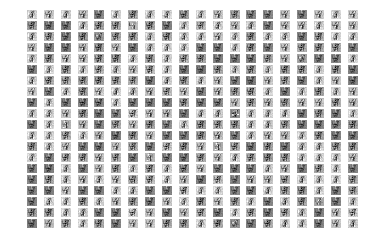

In [53]:
executeSparseAutoencoder(d)

In [51]:
print(opt_W1)

NameError: name 'opt_W1' is not defined